In [13]:
from statistics import linear_regression, LinearRegression
import numpy as np

# 1. t = -v_o +- sqrt(v_o^2+4*(1/2)*a*Δy)/a
def calc_time(y_0,y_f,v_0,a):
    """
    Calculates the positive time of flight for an object under constant acceleration

    Solves the quadratic equation derived from the kinematic equation t = -v_o + sqrt(v_o^2+4*(1/2)*a*Δy)/(a),
    returning the positive root

    Args:
        y_0 (float): initial position (m)
        y_f (float): end position (m)
        v_0 (float): initial speed (m/s)
        a (float): acceleration (m/s^2), 9.81 on earth

    Returns:
        t (float or None): The positive fly time
    """
    return (-v_0 - np.sqrt(v_0**2 + 2 * a * (y_f - y_0))) / a

# 2.Parameters
a = -9.81 # m/s^2
samples = 1000

y0 = np.random.uniform(0, 100000, samples)
y = np.random.uniform(0, y0, samples)
v0 = np.random.uniform(-10000,10000, samples)

data = []

for i in range(samples):
    t = calc_time(y0[i],y[i],v0[i],a)
    data.append([y0[i],y[i],v0[i],t])

# convert to np for AI model
data = np.array(data)

In [14]:
from sklearn.model_selection import train_test_split

# split into train_val 80% and test 20%
train_val_set, test_set = train_test_split(data, test_size=0.2)

train_set, val_set = train_test_split(train_val_set, test_size=0.2)

# split into x and y
x_train = train_set[:, :3]
y_train = train_set[:, 3]
x_val = val_set[:, :3]
y_val = val_set[:, 3]
x_test = test_set[:, :3]
y_test = test_set[:, 3]

from sklearn.preprocessing import RobustScaler

# 3.Data preprocessing

# Apply normalization to our features (y_0, y_f, v_0)
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(x_train)
X_val_scaled = X_scaler.transform(x_val)
X_test_scaled = X_scaler.transform(x_test)

# Apply normalization to our output (t)
Y_scaler = RobustScaler()
Y_train_scaled = Y_scaler.fit_transform(y_train.reshape(-1, 1))
Y_val_scaled = Y_scaler.transform(y_val.reshape(-1, 1))
Y_test_scaled = Y_scaler.transform(y_test.reshape(-1, 1))

In [15]:
# 4.Designing our model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input


# def build_sequential_model(input_dim):
#     """ Build a 3-layer MLP

#     This is an example of how to build a model using the sequential model from the keras library.
#     The only sequential block has three layers, two hidden layers and one output layer. This model doesnt need an input layer,
#     but it needs the dimension of the input.

#     Arg:
#         input_dim (int): input dimension, number of features

#     Returns:
#         model (model): Sequential model
#     """

#     model = Sequential(
#         Dense(64, activation="relu", input_dim=input_dim, name="hidden1"),  # Hidden layer
#         Dense(32, activation="relu", name="hidden2"),  # Hidden layer
#         Dense(1, activation="linear", name="output_layer"),  # Output layer
#     )

#     return model


def build_functional_model(input_dim):
    """ Build a 4-layer MLP

    This is an example of how to build a model using the functional model from the keras library.
    The only functional block has three layers,1 input layer, two hidden layers and one output layer.

    Arg:
        input_dim (int): input dimension, number of features

    Returns:
        model (model): Functional model
    """

    inputs = Input(shape=(input_dim,), name="input_layer")
    x = Dense(64, activation="relu", name="hidden_layer_1")(inputs)
    x = Dense(32, activation="relu", name="hidden_layer_2")(x)
    outputs = Dense(1, activation="linear", name="output_layer")(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model


# def build_hybrid_model(input_dim):
#     """ Build a 3-layer MLP

#     This is an example of how to build a model using both, functional and sequential models from the keras library.
#     The only sequential block has three layers, two hidden layers and one output layer. We don't need to always do both,
#     but the purpose of this demonstration, this is a mixtures of both types of model

#     Arg:
#         input_dim (int): input dimension, number of features

#     Returns:
#         model (model): Sequential model
#     """

#     # Functional part
#     inputs = Input(shape=(input_dim,), name="input")

#     # Sequential part
#     x = Sequential(
#         Dense(64, activation="relu", input_dim=input_dim, name="hidden1"),  # Hidden layer 1
#         Dense(32, activation="relu", name="hidden2")  # Hidden layer 2
#     )

#     outputs = Dense(1, activation="linear")(x)

#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# 5. Compile the model
input_dim = 3
model = build_functional_model(input_dim)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(x=X_train_scaled, y=Y_train_scaled, validation_data=(X_val_scaled, Y_val_scaled), epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4998 - mae: 0.4737 - val_loss: 0.4128 - val_mae: 0.4660
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2362 - mae: 0.3358 - val_loss: 0.1686 - val_mae: 0.3125
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0969 - mae: 0.2398 - val_loss: 0.0596 - val_mae: 0.1954
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - mae: 0.1694 - val_loss: 0.0273 - val_mae: 0.1332
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - mae: 0.1098 - val_loss: 0.0119 - val_mae: 0.0876
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0734 - val_loss: 0.0054 - val_mae: 0.0587
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - mae: 0.0518 - val_loss: 0.0031 - val_mae: 0.0450
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mae: 0.0389 - val_loss: 0.0022 - val_mae: 0.0375
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


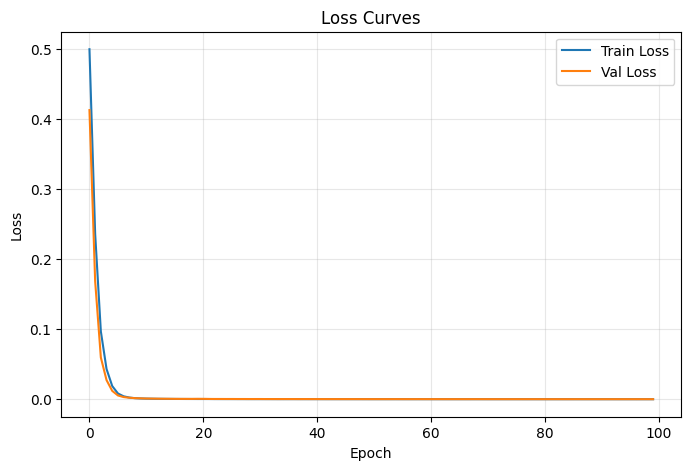

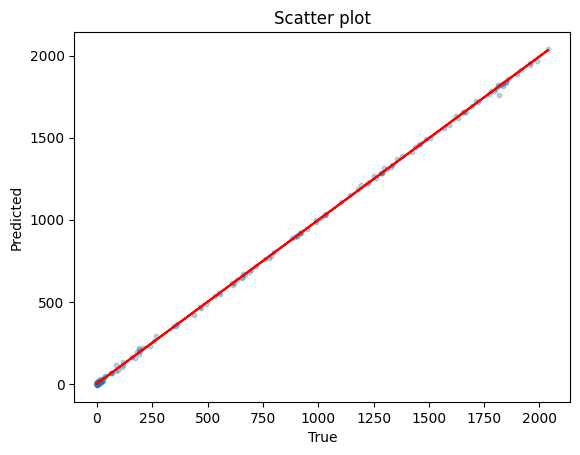

{'mae': 5.640988468456389, 'medianae': 3.913569804160854, 'mse': 68.65472248397114, 'r2': 0.999858269163786, 'mape': 2.1633216455390505, 'mspe': np.float64(193.54346388697732), 'medianape': np.float64(0.04366772539346253)}


In [16]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_percentage_error, median_absolute_percentage_error

# Evaluate our model
def plot_training_curves(history):
    """
    This function plots teh training and validation curves.

    I will use this function to see if the training went correctly and to check for possible over/under fitting of my
    model. If there is a sudden separation of the training and validation curves, that may indicate overfitting.

    Args:
        history (keras.history): history of my model
    """
    plt.figure(figsize=(8,5))
    plt.plot(history.history["loss"],label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_scatter(y_test, y_pred):
    """
    Plot the scatter plot with my test set

    This function plots the scatter plot of one of the set and the regression line to see how well our model fits
    the predictions

    Args:
        y_test (array): test set
        y_pred (array): predictions
    Returns:
        r2: R2 score
    """

    linear_regression = LinearRegression().fit(y_test.reshape(-1,1), y_pred.reshape(-1,1))
    y_fit = linear_regression.predict(y_test.reshape(-1,1))

    r2 = r2_score(y_pred, y_fit)

    plt.figure()
    plt.scatter(y_test, y_pred, label="Test", alpha=0.3, s=10)
    plt.plot(y_test, y_fit, "-r", label=f"Linear Fit (R^2 = {round(r2, 5)})")
    plt.title("Scatter plot")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.show()

    return r2

# Como hemos escalado la información que teníamos, entonces trabajamos ahora sobre los datos escalados
y_pred_scaled = model.predict(X_test_scaled).flatten()
y_pred_scaled = np.array(y_pred_scaled).reshape(-1,1)

y_pred = Y_scaler.inverse_transform(y_pred_scaled).flatten()


plot_training_curves(history)
r2 = plot_scatter(y_test, y_pred)


def further_evaluation(y_test, y_pred, r2):
    """
    Calculate all the metrics

    This function is necessary to calculate all the metrics with the predictions
    on the test set. They are different from the metrics that you obtain while
    training and from which you could also extract information in case your training
    is not procceding as expected.

    Args:
       y_test (numpy_array): true values
       y_pred (numpy_array): predicted values
       r2 (float32): correlation coefficient

    Returns:    
       (dict): Dictionary containing the metrics
    """

    metrics = {
        "mae" : mean_absolute_error(y_test, y_pred),
        "medianae" : median_absolute_error(y_test, y_pred),
        "mse" : mean_squared_error(y_test, y_pred),
        "r2" : r2,
        "mape" : mean_absolute_percentage_error(y_test, y_pred),
        "mspe" : mean_squared_percentage_error(y_test, y_pred),
        "medianape" : median_absolute_percentage_error(y_test, y_pred)
    }
    return metrics 



metrics = further_evaluation(y_test, y_pred, r2)
print(metrics)
